<a href="https://colab.research.google.com/github/Vlad12344/Kaggle-Quick-Draw/blob/master/MobileNet_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import os
import ast
import cv2
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Sequential
from keras.optimizers import Adadelta
from tensorflow import set_random_seed
from  keras.models import model_from_json
from keras.applications import MobileNet, MobileNetV2
from PIL import Image, ImageDraw, ImageOps
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import preprocess_input
from IPython.core.interactiveshell import InteractiveShell
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy

InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14

from google.colab import drive
drive.mount('/content/drive/')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
DP_DIR = '/content/drive/My Drive/colab/shuffle_csvs_new'
INPUT_DIR = '/content/drive/My Drive/colab'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
#np.random.seed(seed=1)
#set_random_seed(seed=1)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories(DIR):
    files = np.load(DIR)
    return sorted([f2cat(f) for f in files], key=str.lower)

In [0]:
def apk(actual, predicted, k=3):
   
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, 0:3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
STEPS = 100
EPOCHS = 100
size = 64
batchsize = 1300

In [0]:
optim = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
optim_2 = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08) 
weig = '/content/drive/My Drive/colab/MobiV2_generator_64_fine_tune.h5'

model = MobileNetV2(input_shape=(size, size, 1), alpha=1, weights=weig, classes=NCATS)
model.compile(optimizer=optim_2, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img
    
def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
  while True:
    k = np.random.randint(ks)
    filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
    for df in pd.read_csv(filename, chunksize=batchsize):
      df['drawing'] = df['drawing'].apply(ast.literal_eval)
      x = np.zeros((len(df), size, size, 1))
      for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw)
      x = preprocess_input(x).astype(np.float32)
      y = np_utils.to_categorical(df.y, num_classes=NCATS)
      yield x, y
        
def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = preprocess_input(x).astype(np.float32)
    return x    

In [0]:
k = np.random.randint(99)
print(k)

18


In [8]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 2)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = np_utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [0]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=NCSVS - 1)

In [12]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)]

hists = []
for i in range(EPOCHS):
    hist = model.fit_generator(
           train_datagen, steps_per_epoch=STEPS, epochs=1, verbose=1,
           validation_data=(x_valid, y_valid))
    hists.append(hist)
  
    model.save_weights(os.path.join(INPUT_DIR, 'MobiV2_generator_64_fine_tune.h5'))

Epoch 1/1
100/100 [==============================] - 130s 1s/step - loss: 1.3422 - acc: 0.6327 - val_loss: 1.4319 - val_acc: 0.6208
Epoch 1/1
100/100 [==============================] - 118s 1s/step - loss: 1.2559 - acc: 0.6517 - val_loss: 1.4370 - val_acc: 0.6224
Epoch 1/1
100/100 [==============================] - 118s 1s/step - loss: 1.1711 - acc: 0.6726 - val_loss: 1.4570 - val_acc: 0.6139
Epoch 1/1
100/100 [==============================] - 121s 1s/step - loss: 1.1050 - acc: 0.6890 - val_loss: 1.4594 - val_acc: 0.6148
Epoch 1/1
 99/100 [============================>.] - ETA: 1s - loss: 1.0640 - acc: 0.7002

KeyboardInterrupt: ignored

In [0]:
model.save_weights(os.path.join(INPUT_DIR, 'quick_doodle_MobiV2_generator_128.h5'))

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

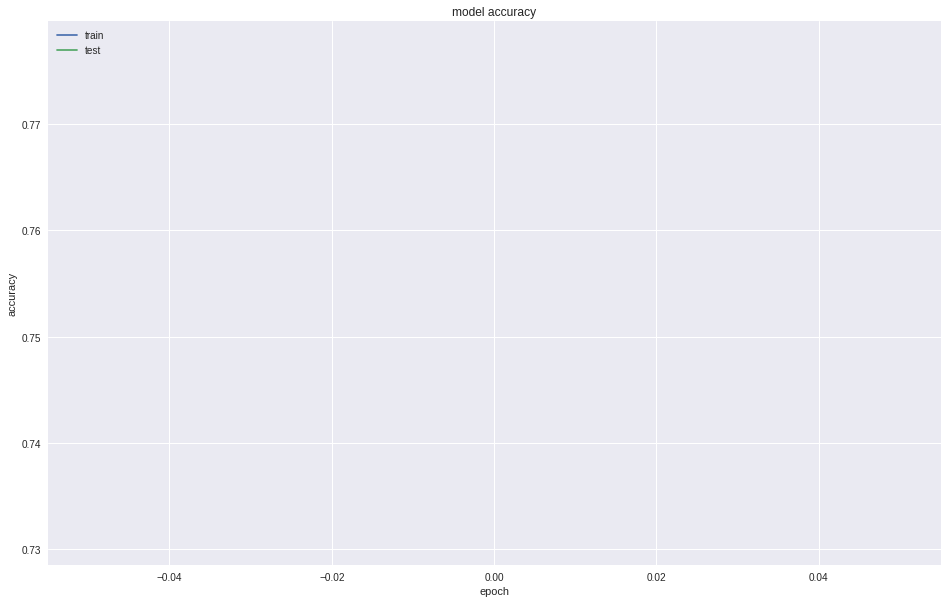

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

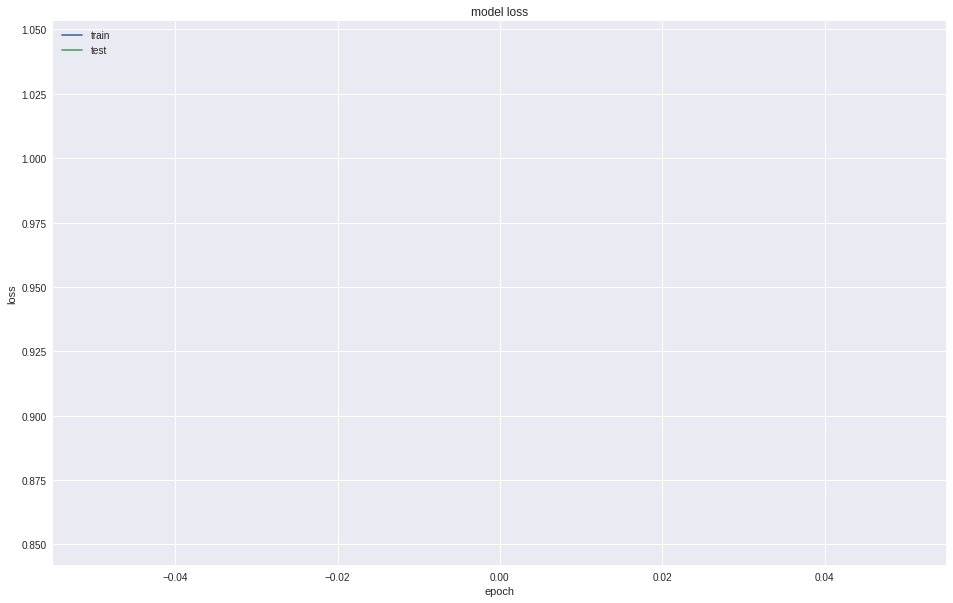

In [0]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
test = pd.read_csv(os.path.join(DP_DIR, 'test_simple', 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


In [0]:
model = MobilNetV2()
# Загружаем веса в модель
loaded_model.load_weights('/content/drive/My Drive/colab/quick_doodle_MobiV2_generator_128.h5')

In [0]:
#test_predictions = loaded_model.predict(x_test, batch_size=128, verbose=1)
test = pd.read_csv(os.path.join(DP_DIR, 'test_simple', 'test_simplified.csv'))
test_prediction_1 = np.load(os.path.join(INPUT_DIR, 'predicts', 'predict_MobiV2_128_1.npy'))
test_prediction_2 = np.load(os.path.join(INPUT_DIR, 'predicts', 'predict_MobiV2_128_2.npy'))
test_predictions= np.concatenate((test_prediction_1, test_prediction_2), axis = 0 )

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories('/content/drive/My Drive/colab/classes.npy')
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('/content/drive/My Drive/colab/gs_mn_submission_64.csv', index=False)
submission.head()
submission.shape

,a,b,c
0,234,281,316
1,144,36,226
2,305,62,53
3,187,236,303
4,113,56,165


(112199, 3)

,a,b,c
0,radio,stereo,traffic_light
1,hockey_puck,bottlecap,pool
2,The_Great_Wall_of_China,castle,camel
3,mountain,rainbow,tent
4,fireplace,campfire,leaf


(112199, 3)

,key_id,word
0,9000003627287624,radio stereo traffic_light
1,9000010688666847,hockey_puck bottlecap pool
2,9000023642890129,The_Great_Wall_of_China castle camel
3,9000038588854897,mountain rainbow tent
4,9000052667981386,fireplace campfire leaf


(112199, 2)